In [119]:
import os
import logging
from tqdm import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from dataset import Galaxy_Dataset
from models.Unrolled_ADMM import Unrolled_ADMM
from models.Richard_Lucy import Richard_Lucy
from utils.utils import estimate_shear

%matplotlib inline

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [120]:
betas = [0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
n_rejects_obs, n_rejects_fpfs, n_rejects_rl, n_rejects_admm = [], [], [], []
obs_error_mean, fpfs_error_mean, rl_error_mean, admm_error_mean = [], [], [], []
method = 'No_deconv'
n_gal = 10000

In [121]:
model_rl = Richard_Lucy(n_iters=20)
model_rl.to(device)
model_rl.eval()

model_admm = Unrolled_ADMM(n_iters=4, llh='Poisson', PnP=True)
model_admm.to(device)
model_file = 'saved_models/Poisson_PnP_4iters_LSST23.5_50epochs.pth'
model_admm.load_state_dict(torch.load(model_file, map_location=torch.device(device)))
model_admm.eval()

Unrolled_ADMM(
  (init): InitNet(
    (conv_layers): Sequential(
      (0): Down(
        (maxpool_conv): Sequential(
          (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (1): DoubleConv(
            (double_conv): Sequential(
              (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU(inplace=True)
              (3): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (4): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (5): ReLU(inplace=True)
            )
          )
        )
      )
      (1): Down(
        (maxpool_conv): Sequential(
          (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
          (1): DoubleConv(
            (double_conv): Sequential(
              (0): Conv2d(4, 8, ker

In [122]:
test_dataset = Galaxy_Dataset(train=False, survey='LSST', I=23.5, obs_folder='obs_10/', gt_folder='gt_10/')
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

psf_delta = np.zeros([48, 48])
psf_delta[23,23] = 1
    
for beta in betas:
    n_reject_obs, n_reject_fpfs, n_reject_rl, n_reject_admm = 0, 0, 0, 0
    gt_shear, obs_shear, fpfs_shear, rl_shear, admm_shear = [], [], [], [], []
    for (idx, ((obs, psf, alpha), gt)), _ in zip(enumerate(test_loader), tqdm(range(n_gal))):
        with torch.no_grad():
            obs, psf, alpha = obs.to(device), psf.to(device), alpha.to(device)
            # RL
            rec_rl = model_rl(obs, psf) 
            rec_rl = rec_rl.squeeze(dim=0).squeeze(dim=0).cpu().numpy()
            try:
                rl_shear.append(estimate_shear(rec_rl, psf_delta, beta=beta))
            except:
                rl_shear.append((gt_shear[idx][0],gt_shear[idx][1],gt_shear[idx][2]+1))
                n_reject_rl += 1
            
            # ADMM
            rec_admm = model_admm(obs, psf, alpha) 
            rec_admm = rec_admm.squeeze(dim=0).squeeze(dim=0).cpu().numpy()
            try:
                admm_shear.append(estimate_shear(rec_admm, psf_delta, beta=beta))
            except:
                admm_shear.append((gt_shear[idx][0],gt_shear[idx][1],gt_shear[idx][2]+1))
                n_reject_admm += 1
            
            psf = psf.squeeze(dim=0).squeeze(dim=0).cpu().numpy()
            obs = obs.squeeze(dim=0).squeeze(dim=0).cpu().numpy()
            gt = gt.squeeze(dim=0).squeeze(dim=0).cpu().numpy()
            
            gt_shear.append(estimate_shear(gt, psf_delta, beta=beta))
            try:
                obs_shear.append(estimate_shear(obs, psf_delta, beta=beta))
            except:
                fpfs_shear.append((gt_shear[idx][0],gt_shear[idx][1],gt_shear[idx][2]+1))
                n_reject_obs += 1
            try:
                fpfs_shear.append(estimate_shear(obs, psf, beta=beta))
            except:
                fpfs_shear.append((gt_shear[idx][0],gt_shear[idx][1],gt_shear[idx][2]+1))
                n_reject_fpfs += 1
                

        if idx >= n_gal:
            break
    n_rejects_obs.append(n_reject_obs)
    n_rejects_fpfs.append(n_reject_fpfs)
    n_rejects_rl.append(n_reject_rl)
    n_rejects_admm.append(n_reject_admm)
    
    gt_shear = np.array(gt_shear)
    obs_err = np.abs(obs_shear - gt_shear)
    obs_error_mean.append(np.mean(obs_err[:,2]))
    fpfs_err = np.abs(fpfs_shear - gt_shear)
    fpfs_error_mean.append(np.mean(fpfs_err[:,2]))
    rl_err = np.abs(rl_shear - gt_shear)
    rl_error_mean.append(np.mean(rl_err[:,2]))
    admm_err = np.abs(admm_shear - gt_shear)
    admm_error_mean.append(np.mean(admm_err[:,2]))


100%|██████████| 10000/10000 [03:29<00:00, 47.66it/s]


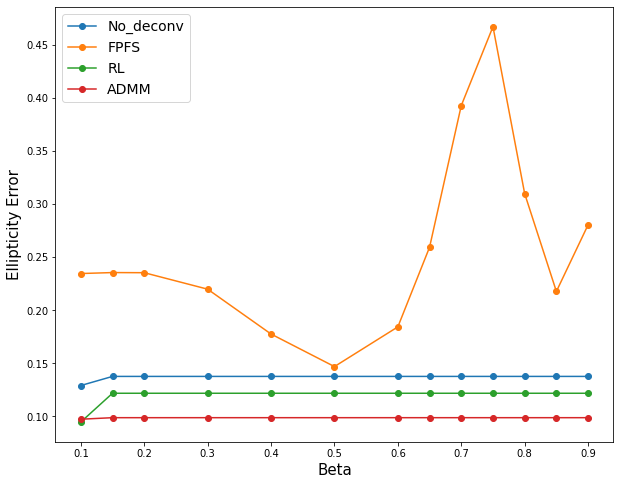

In [123]:
fig, ax1 = plt.subplots(figsize=(10,8), facecolor='white')
ax1.plot(betas, obs_error_mean, '-o', label='No_deconv')
ax1.plot(betas, fpfs_error_mean, '-o', label='FPFS')
ax1.plot(betas, rl_error_mean, '-o', label='RL')
ax1.plot(betas, admm_error_mean, '-o', label='ADMM')
ax1.set_xlabel('Beta', fontsize=15)
ax1.set_ylabel('Ellipticity Error', fontsize=15)
plt.legend(fontsize=14)

In [124]:
print(n_rejects_obs, n_rejects_fpfs, n_rejects_rl, n_rejects_admm)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 32, 149, 542, 1239] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
